Давайте попробуем решить еще одну задачу. Имеется поток научных статей на русском и украинском языках. Необходимо автоматически определить язык статьи.<br>
Для решения данной задачи можно использовать один из двух подходов: словарный и алфавитный. В первом мы выделяем слова и проверяем какому алфавиту они относятся. Так, например, фраза <i>"Вони аналiзувались з метою виключення грубих помилок"</i> очевидно относится к украинскому языку, тогда как фраза "Они анализировались с целью исключения грубых ошибок" написана на русском. Однако, подобный подход требует наличия словарей соответствующих языков. Поэтому проще подсчитать статистику встречаемости букв и решить задачу класификации по ним.<br>
Для начала нам снова надо векторизовать пришедший текст. 

In [1]:
from collections import Counter
import numpy as np

import codecs # Чтобы не было проблем с кодировками.

In [2]:
# Считываем файл со статьями, делим его на статьи, строим словарь с частотами букв для каждой статьи.
def loadLanguage(filename) -> (list, list):
    with codecs.open(filename, "rb", "utf-8") as infile:
        all_text=infile.read()
    article_texts=all_text.lower().split('=====\n')
    characters=[Counter(art) for art in article_texts]
#    characters2=[Counter([art[i]+art[i+1] for i in range(len(art)-1)]) for art in article_texts]
    return article_texts, characters

# Формируем общий алфавит для всех коллекций статей.
def formAlphabet(characters) -> dict:
    alphabet={}
    for ch in characters:
        for a in ch:
            alphabet.update(a)
    for i, k in enumerate(alphabet.keys()):
        alphabet[k]=i
    return alphabet

# Нормируем абсолютные частоты на сумму частот в каждой статье.
def normalizeSet(characters, alphabet, learning_set, shift=0):
    for i, cs in enumerate(characters):
        pos=shift+i
        for c in cs.keys():
            if c in alphabet.keys():
                learning_set[pos, alphabet[c]]=cs[c]
        learning_set[pos]/=sum(learning_set[pos])

# Считываем обучающие и тестовую выборки.
ukr_article_texts, ukr_characters = loadLanguage('/home/edward/projects/TEST/getRusCorpora/Python/ukr_articles.txt')
rus_article_texts, rus_characters = loadLanguage('/home/edward/projects/TEST/getRusCorpora/Python/rus_articles.txt')
test_article_texts, test_characters = loadLanguage('/home/edward/projects/TEST/getRusCorpora/Python/test_articles.txt')

# Формируем алфавит.
alphabet= formAlphabet([ukr_characters, rus_characters])

# Нормализуем обучающие выборки и формируем вектор с номерами классов для них.
learning_set=np.zeros((len(ukr_article_texts)+len(rus_article_texts), len(alphabet.keys())))
normalizeSet(ukr_characters, alphabet, learning_set)
normalizeSet(rus_characters, alphabet, learning_set, len(ukr_article_texts))

classes=np.ones((len(ukr_article_texts)+len(rus_article_texts), ))
classes[len(ukr_article_texts):]=2

# Нормализуем тестовую выборку и формируем для нее вектор с номерами классов.
test_set=np.zeros((len(test_article_texts), len(alphabet.keys())))
normalizeSet(test_characters, alphabet, test_set)

test_classes=np.ones((len(test_article_texts), ))
test_classes[:33]=2


Теперь попробуем на этих данных обучить <b>логистическую регрессию</b>.<br>
Натренируем модель на обучающей выборке, попробуем предсказать результат на тестовой выборке.<br>
Также, построим <a href="https://en.wikipedia.org/wiki/Confusion_matrix">матрицу ошибок</a>, которая будет показывать нам где модель ошибается больше всего.<br><br>
Кстати, вы обратили внимание на форматирование? А ведь оно сделано тоже при помощи HTML! <br> Для кого-то это может быть хорошим поводом познакомиться.

In [3]:
import sklearn.linear_model as sklinear

In [4]:
# Создаем объект для логистической регрессии.
model=sklinear.LogisticRegression()
# Проводим обучение на обучающей выборке.
model.fit(learning_set, classes)
#print(model.coef_)
# Строим предсказание для тестовой выборки.
predicted=model.predict(test_set)
# Строим матрицу ошибок.
errors=np.zeros((2,2))
for i, p in enumerate(predicted):
    errors[int(p)-1][int(test_classes[i])-1]+=1
#for i, p in enumerate(predicted):
#    if p!=test_classes[i]:
#        errors[int(p-1)][int(test_classes[i]-1)]+=1
#    else:
#        errors[int(p-1)][int(p-1)]+=1
#print(predicted)
print(errors)


[[33. 33.]
 [ 0.  0.]]


Что-то явно пошло не так. Модель классифицирует все статьи как русские. Хорошо бы понять почему.<br>
Для этого здорово было бы взглянуть на получившиеся точки. Но для этого необходимо отобразить пространство размерностью около сотни параметров.<br>
Один из методов такого отображения состоит в том, что мы преобразуем пространство в новое, имеющее меньшую размерность. Например, метод PCA (<i>Principle Component Analysis</i>) находит новую ось, которая направлена вдоль направления наибольшей дисперсии наших точек. Далее строится проекция всех точек на эту ось. Таким образом получаетсяя первая координата в новом пространстве. Это направление отбрасывается, после чего можно снова попытаться найти еще одну ось, еще одну и т.д. Операцию можно повторить необходимое количество раз.<br>
Импортируем библиотеки, необходимые для такого преобразования, а также для отображения полученного пространства.

In [5]:
from sklearn.decomposition import PCA

%matplotlib notebook
import matplotlib.pyplot as plt

По умолчанию PCA строит двумерное преставление нашего пространства. При помощи функции fit_transform мы настраиваем коэффициенты преобразования (fit) и преобразуем переданные точки (transform). Каждое из этих действий для PCA можно производить по отдельности.<br>
Далее отобразим эти точки на плоскости при помощи библиотеки MatPlotLib.

<IPython.core.display.Javascript object>


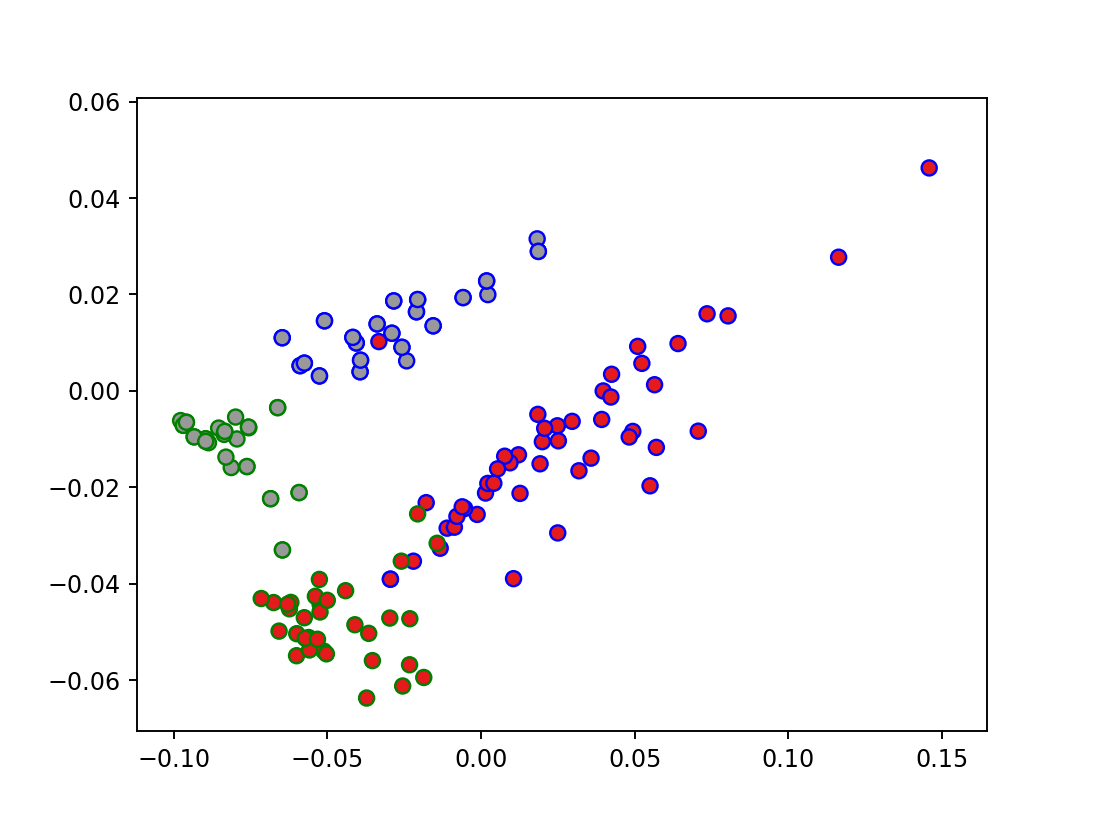

In [6]:
# Создаем модель для преобразования пространства. 
pca=PCA()
# Настраиваем коэффициенты модели и преобразуем обучающую выборку в двумерное пространство.
show_reduced = pca.fit_transform(learning_set)
# По полученным коэффициентам преобразовываем тестовую выборку.
test_reduced=pca.transform(test_set)
# Создаем рисунок и оси.
fig, ax = plt.subplots()
# Рисуем преобразованные обучающую и тестовыые выборки.
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], c=classes,
           cmap=plt.cm.Set1, edgecolor='b', s=40)
ax.scatter(test_reduced[:, 0], test_reduced[:, 1], c=test_classes,
           cmap=plt.cm.Set1, edgecolor='g', s=40)
plt.show()



Метод MDS (<i>Multidimensional Scaling</i>) поступает примерно по тому же принципу, но работает несколько быстрее и лучше. Однако в отличие от PCA он не умеет сохранять коэффициенты преобразования и использовать их для преобразования новых данных.

In [7]:
from sklearn.manifold import MDS

<IPython.core.display.Javascript object>


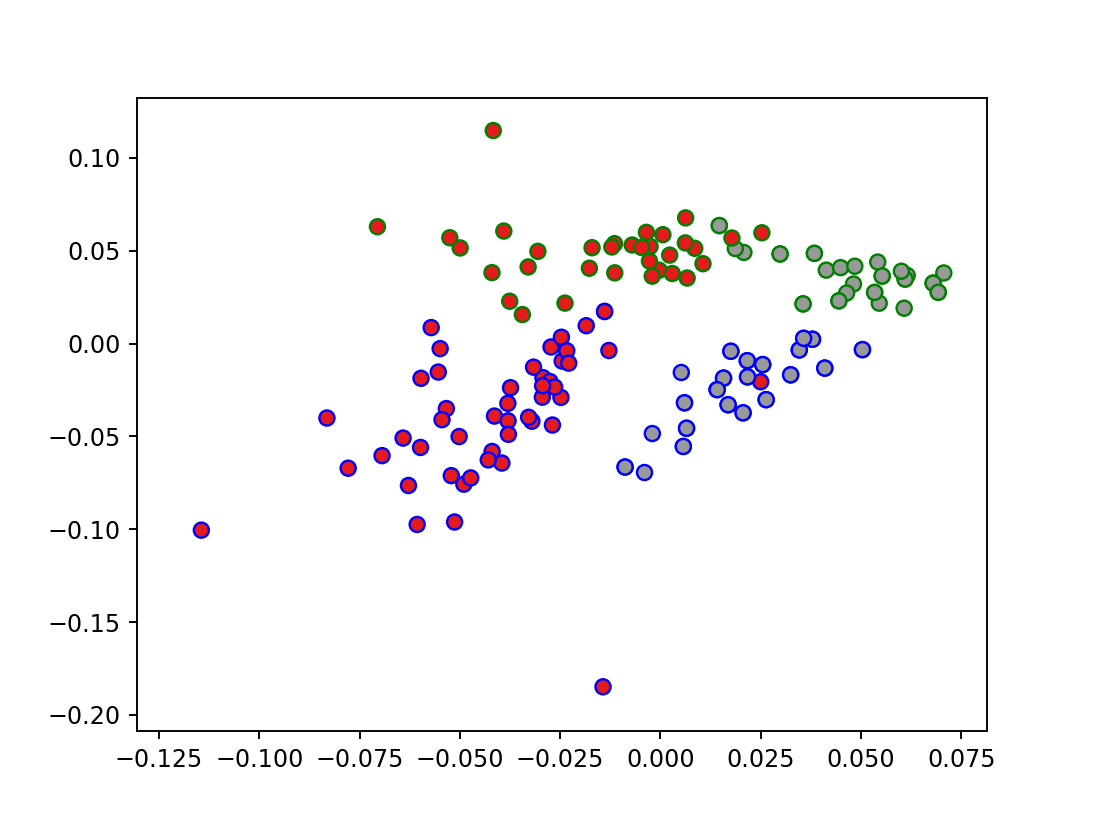

In [8]:
# Объединим две выборки, чтобы преобразовать их за один раз.
show_set=np.concatenate((learning_set, test_set))

# MDS начинает из случайной точки.
# random_state позволяет задать эту точку, чтобы получать один и тот же результат при разных прогонах.
mds=MDS(random_state=1023)
show_reduced = mds.fit_transform(show_set)

fig, ax = plt.subplots()
ax.scatter(show_reduced[:len(learning_set), 0], show_reduced[:len(learning_set), 1], c=classes,
           cmap=plt.cm.Set1, edgecolor='b', s=40)
ax.scatter(show_reduced[len(learning_set):, 0], show_reduced[len(learning_set):, 1], c=test_classes,
           cmap=plt.cm.Set1, edgecolor='g', s=40)
plt.show()


Еще одним методом является t-SNE (<i>t-distributed stochastic neighbor embedding</i>). В отличие от предыдущих двух методов, он не строит проекции, а пытается "вдавить" точки в пространство заданной размерности, соблюдая при этом примерное расположение точек. Очевидно, полностью сохранить расположение получается не всегда, но алгоритм старается сделать так, чтобы соседние точки остались соседними.<br>
Как и MDS, t-SNE принципиально не умеет сохранять правила преобразования пространства, так что преобразовыать надо все точки сразу.

In [9]:
from sklearn.manifold import TSNE

<IPython.core.display.Javascript object>


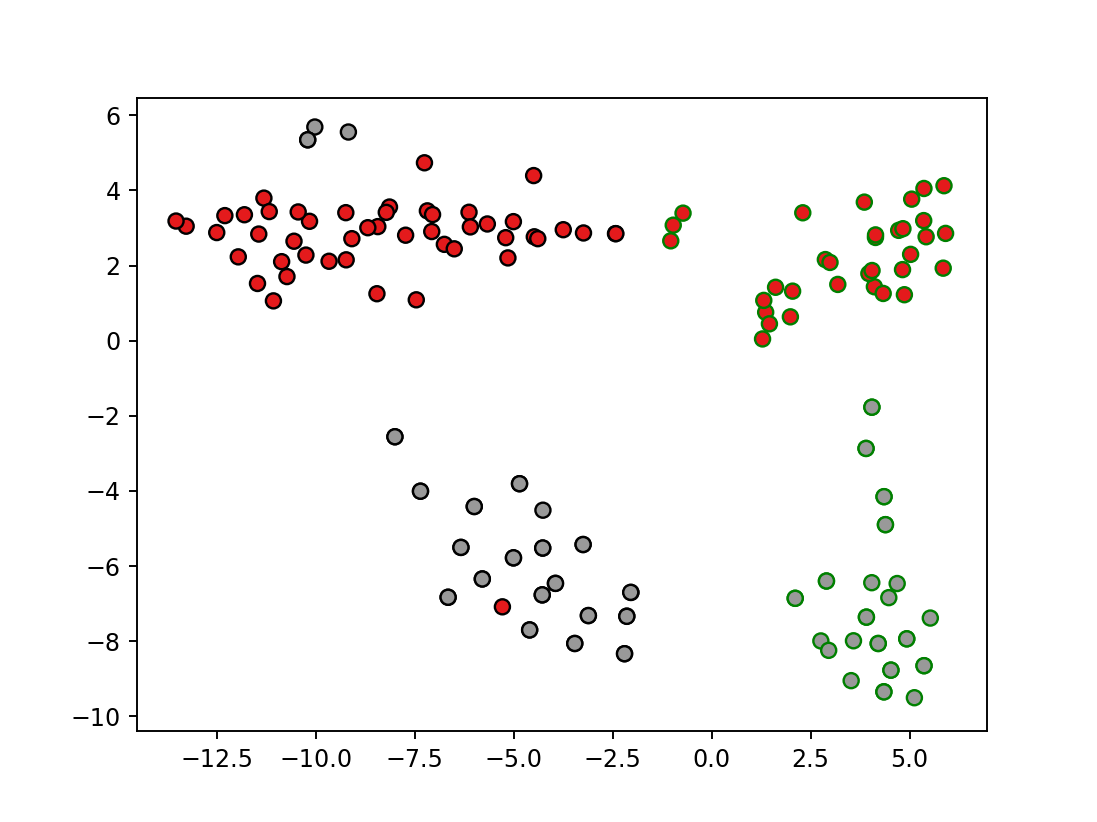

In [10]:
# Создаем объект TSNE, преобразовываем все точки.
tsne=TSNE()
show_reduced = tsne.fit_transform(show_set)

# Отрисовываем полученное отображение.
fig, ax = plt.subplots()
ax.scatter(show_reduced[:len(learning_set), 0], show_reduced[:len(learning_set), 1], c=classes,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.scatter(show_reduced[len(learning_set):, 0], show_reduced[len(learning_set):, 1], c=test_classes,
           cmap=plt.cm.Set1, edgecolor='g', s=40)
plt.show()


Наконец, алгоитм, который появился в 2018 году - UMAP (<i>Uniform Manifold Approximation and Projection</i>). Принцип работы аналогичен t-SNE. Посмотрим и на его результаты.

In [11]:
import umap

<IPython.core.display.Javascript object>


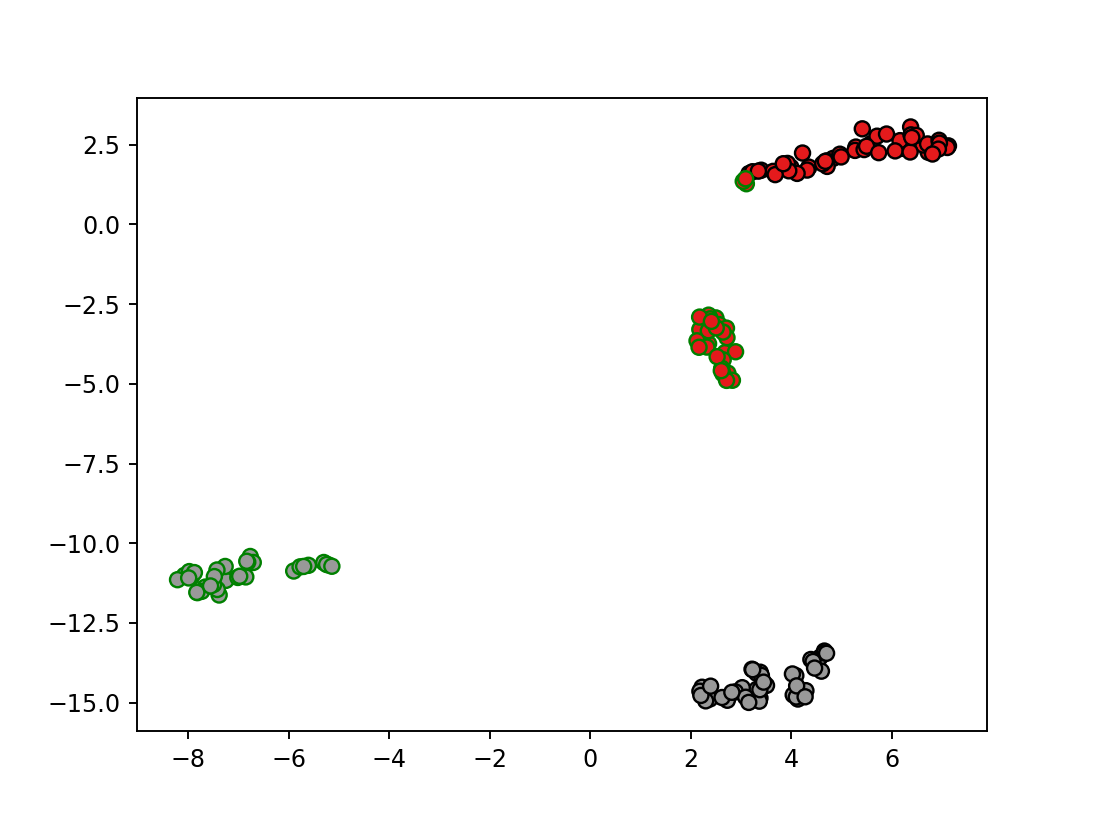

In [12]:
umap_emb=umap.UMAP()

show_reduced=umap_emb.fit_transform(show_set)

# Отрисовываем полученное отображение.
fig, ax = plt.subplots()
ax.scatter(show_reduced[:len(learning_set), 0], show_reduced[:len(learning_set), 1], c=classes,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.scatter(show_reduced[len(learning_set):, 0], show_reduced[len(learning_set):, 1], c=test_classes,
           cmap=plt.cm.Set1, edgecolor='g', s=40)
plt.show()


Попробуем решить задачу при помощи UMAP.

In [13]:
show_set=np.concatenate((learning_set, test_set))

show_reduced = umap_emb.fit_transform(show_set)

learning_reduced = show_reduced[:len(learning_set)]
test_reduced = show_reduced[len(learning_set):]

model.fit(learning_reduced, classes)
predicted=model.predict(test_reduced)
errors=np.zeros((2,2))
for i, p in enumerate(predicted):
    errors[int(p)-1][int(test_classes[i])-1]+=1
print(predicted)
print(errors)
#print(test_article_texts[39])

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[33.  0.]
 [ 0. 33.]]


Превосходно!<br><br>
В ходе анализа мы могли увидеть несколько вещей.<br>
Во-первых, данные устроены так, что они должны были разделиться даже линейной регрессией. Но что-то пошло не так. Скорее всего у нас просто слишком много параметров и регрессия не может нормально принять решение из-за большого шума.<br>
Во-вторых, мы видим, что обучающая и тестовая выборка серьезно отличаются. Да, разные языки в них могут быть отделены всё той же линией, но и обучающая и тестовая выборки тоже могут быть отделены друг от друга. Это произошло из-за того, что обучающая выборка была взята из статей по архитектуре, а тестовая - по информационным технологиям. Судя по всему, мо можем классифицировать тематику статей по <b>статистике употребления букв</b>.
И пользоваться нам всё равно придется PCA, поскольку только он умеет обучиться на одних данных, а потом преобразовывать другие.

In [14]:
# Создаем модель для преобразования пространства. 
pca=PCA(n_components=2)
# Настраиваем коэффициенты модели и преобразуем обучающую выборку в двумерное пространство.
show_reduced = pca.fit_transform(learning_set)
# По полученным коэффициентам преобразовываем тестовую выборку.
test_reduced=pca.transform(test_set)

model.fit(show_reduced, classes)

predicted=model.predict(test_reduced)
errors=np.zeros((2,2))
for i, p in enumerate(predicted):
    if p!=test_classes[i]:
        errors[int(p)-1][int(test_classes[i])-1]+=1
print(errors)


[[ 0. 33.]
 [ 0.  0.]]


Но PCA всё еще не работает, хотя должен был бы. Давайте попробуем разобраться что происходит. Может быть надо было взять больше параметров? Давайте попробуем отобразить всё в трехмерке.

In [15]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


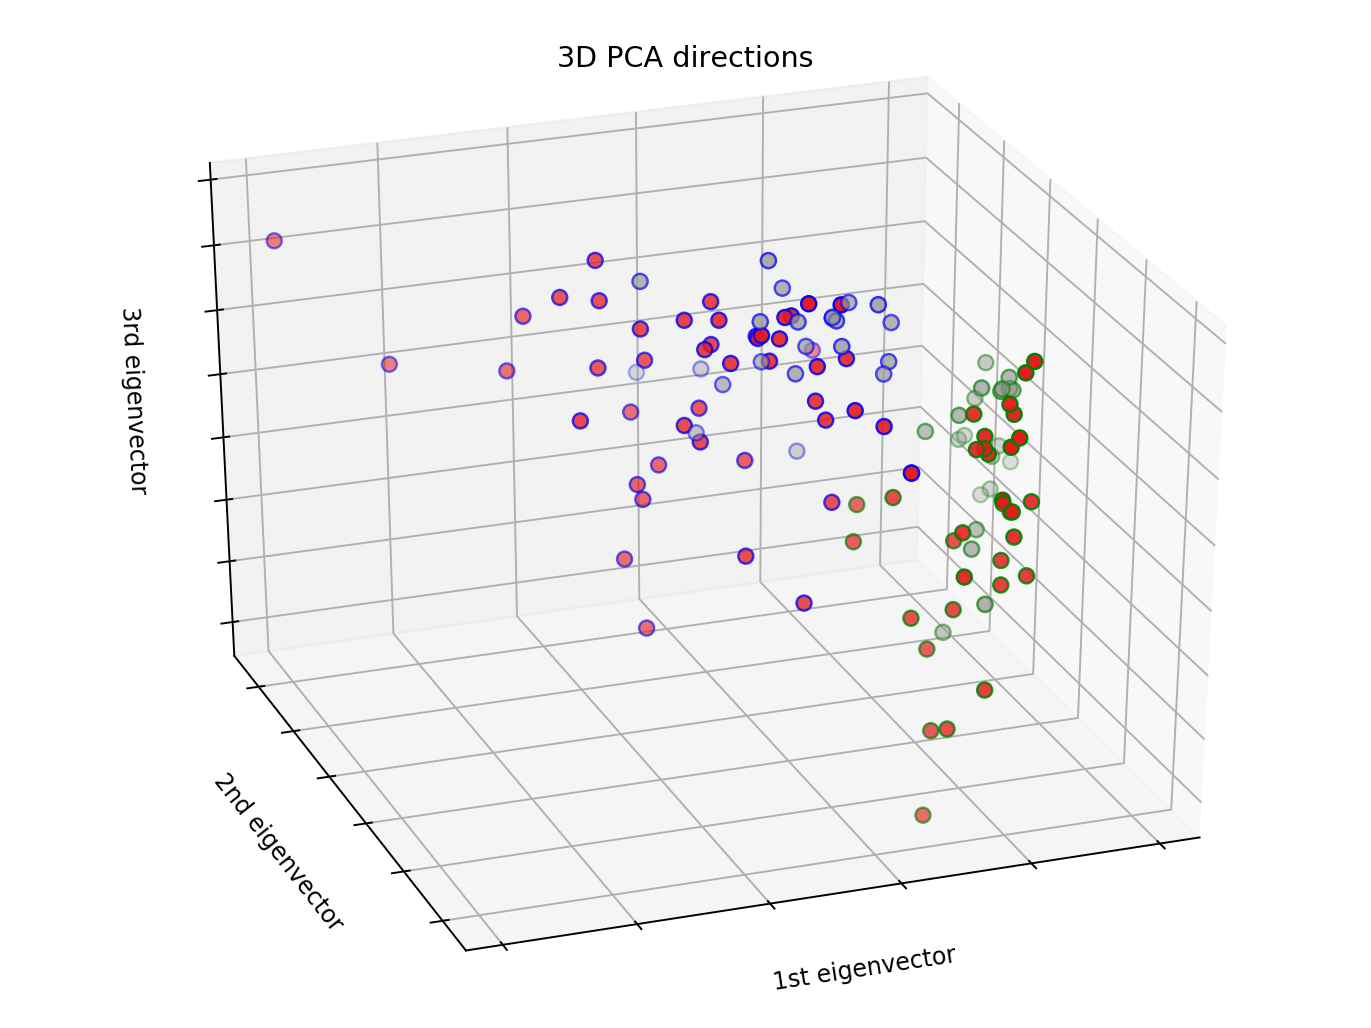

In [16]:
pca=PCA(n_components=3)
show_reduced = pca.fit_transform(learning_set)

test_reduced=pca.transform(test_set)

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(show_reduced[:, 0], show_reduced[:, 1], show_reduced[:, 2], c=classes,
           cmap=plt.cm.Set1, edgecolor='b', s=40)
ax.scatter(test_reduced[:, 0], test_reduced[:, 1], test_reduced[:, 2], c=test_classes,
           cmap=plt.cm.Set1, edgecolor='g', s=40)
ax.set_title("3D PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

Может быть в четырех измерениях будет лучше?

In [17]:
import seaborn as sns
import pandas as pd

<IPython.core.display.Javascript object>


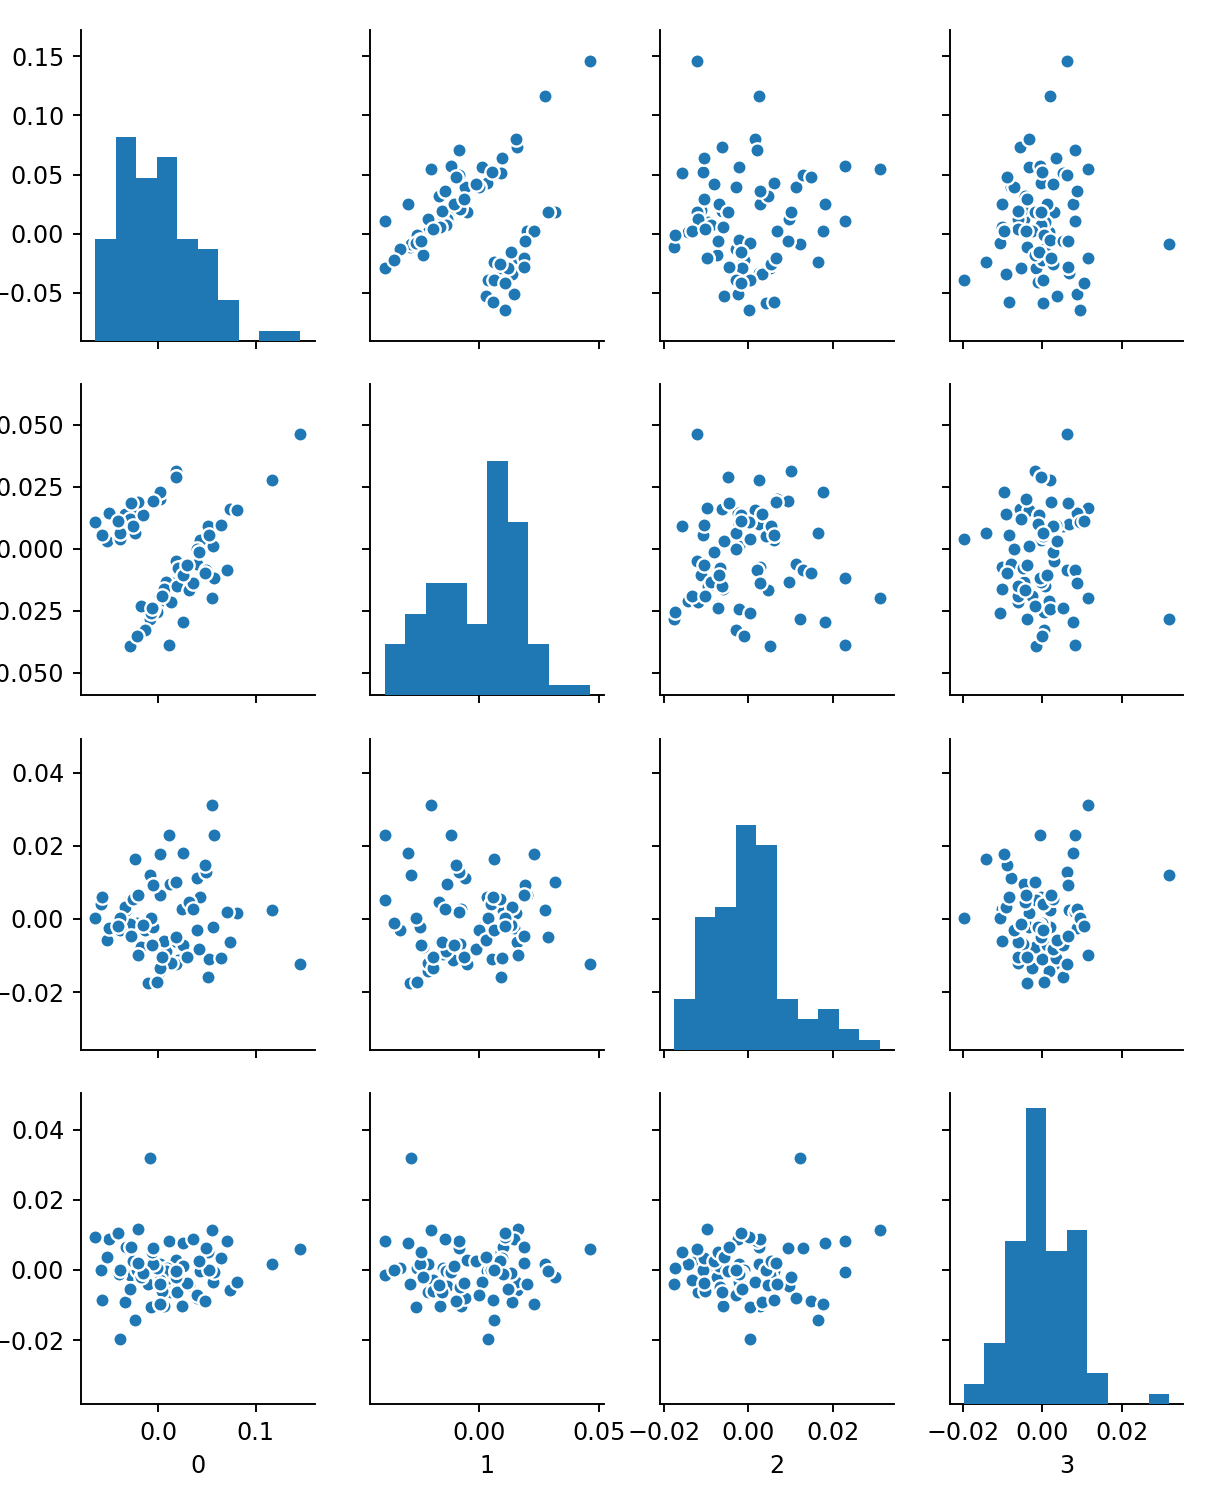

<IPython.core.display.Javascript object>


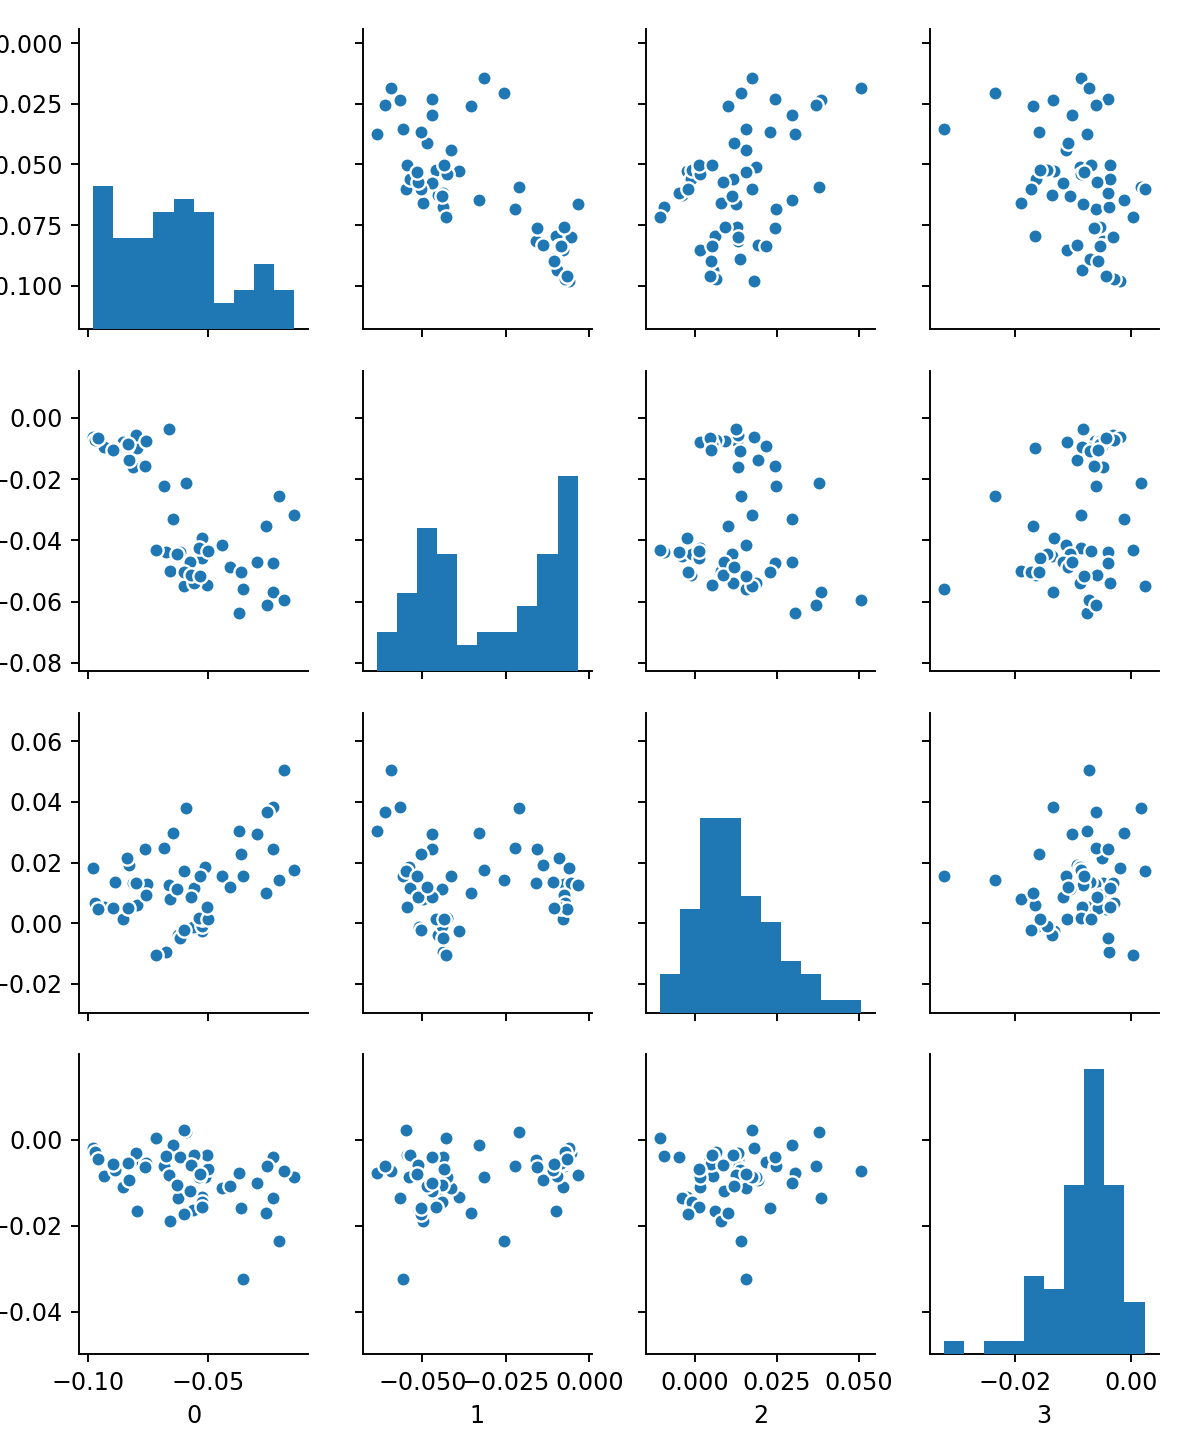

In [18]:
pca=PCA(n_components=4)
show_reduced = pca.fit_transform(learning_set)

test_reduced=pca.transform(test_set)

s_data=pd.DataFrame(show_reduced)
sns_plot = sns.pairplot(s_data)
sns_plot = sns.pairplot(pd.DataFrame(test_reduced))

А теперь выведем каким буквам соответствуют самые большие коэффициенты регрессии.<br>
Оказывается, классифицировать русские и украинские тексты можно просто посмотрев на чатоты встречаемости букв <i>i</i> и <i>и</i>. Из 141 параметра модели основное влияние оказывают лишь два! Если исправить коэффициенты логистической регрессии, то можео получить неплохие результаты.

In [19]:
model=sklinear.LogisticRegression()
model.fit(learning_set, classes)
#print(model.coef_)
predicted=model.predict(test_set)
errors=np.zeros((2,2))
for i, p in enumerate(predicted):
    errors[int(p)-1][int(test_classes[i])-1]+=1
print(predicted)
print(errors)

print(model.coef_.shape)
for i in range(model.coef_.shape[1]):
    if abs(model.coef_[0][i])<3e-1:
        model.coef_[0][i]=0
    else:
        k1='@'
        for k in alphabet.keys():
            if alphabet[k]==i:
                k1=k
                break
        print(k1, i)
model.coef_[0]=0
model.coef_[0][42]=-0.5
model.coef_[0][51]=8
#print(model.coef_)
predicted=model.predict(test_set)
predicted=3-predicted
errors=np.zeros((2,2))
for i, p in enumerate(predicted):
    errors[int(p-1)][int(test_classes[i]-1)]+=1
print(predicted)
print(errors)

#print(learning_set[0])

print(learning_set[:,51])
print(test_set[:,51])


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[33. 33.]
 [ 0.  0.]]
(1, 141)
с 9
  25
i 31
и 51
о 104
е 120
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[32. 33.]
 [ 1.  0.]]
[0.04061593 0.0395099  0.03676815 0.03808929 0.04000301 0.03604774
 0.04546133 0.03185512 0.03714228 0.03592853 0.05930077 0.04722327
 0.04722327 0.03576294 0.03664921 0.03363344 0.03696657 0.03833469
 0.03986761 0.0396485  0.03665966 0.04409797 0.04222451 0.04013753
 0.03660811 0.02989272 0.04610569 0.0481292  0.04548193 0.03415085
 0.05006251 0.03778089 0.04614008 0.03744928 0.04197652 0.02704754
 0.037137   0.04142179 0.03106102 0.03571429 0.04128564 0.03511666
 0.04227768 0.03004836 0.0257612  0.03627

<hr color="black" size="8">

А теперь вернемся от научных статей к новостям. <br>
Оформим наш класс загрузки новостей с Ленты в виде отдельного питоновского модуля и импортируем оттуда сам класс и функцию расчета косинусной меры сходства. Вот оно удобство классов: пишешь однажды, используешь всегда!

In [20]:
from getnewspaper import getNewsPaper
from getnewspaper import cosineSimilarity

Теперь попробуем применить для решения той же задачи модель Word2Vec, основная идея которой состоит в следующем. До сих пор мы работали в пространстве, размерность которого составляет несколько десятков, а может быть и сотен, тысяч измерений - по количеству используемых слов. Однако рядом будут находиться измерения для слов "бегемот" и "гиппопотам", являющихся синонимами. Следовательно, удалив одинаковые слова, мы можем снизить размерность пространства и уменьшить количество вычислений.<br>
Более того, каждое слово может быть выражено при помощи некоторых базовых понятий. Давайте попробуем отобразить теперь каждое слово в новое пространство, измерениями которого будут эти базовые понятия. Например, "король" будет раскладываться по измерениям "люди" (со значениями <b>"мужчина"</b> и "женщина"), "возраст" ("молодой", <b>"зрелый"</b>, "старый"), "власть" (<b>"верховная"</b>, "среднее звено", "местная", "локальная") и другим. При этом координаты не обязаны принимать заданные дискретные значения.<br>
Координаты слова в новом семантическом пространстве будут задаваться соседними словами. "Кушать" будет попадаться чаще с живыми существами, едой или посудой; "бегать" можно по некоторым местам и т.д. Правда, глаза могут и бегать, и есть. Это не будет добавлять модели детерминизма.<br>
Чтобы не мучиться в выбором новой системы координат натренируем некоторую модель, которая сама будет проводить уменьшение размерности пространства, а нам будет оставаться только выбрать число измерений. Эта же модель будет заниматься преобразованием точек старого пространства в новое. В этом новом семантическом пространстве становятся возможны векторные операции - сложение и вычитание. Разработчики модели Word2Vec утверждают, что они смогли получить "King"+"Man"-"Woman"="Queen". Посмотрим, получится ли у нас.

In [21]:
# Импортируем библиотеки Word2Vec
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models.word2vec import LineSentence # Выравнивание текста по предложениям.
from gensim.models import KeyedVectors # Семантические вектора.
# На самом деле, нам потребуется только последняя.
import numpy as np # Вектора.

Теперь загрузим модель, обученную разработчиками проекта <a href="http://rusvectores.org/ru/models/">RusVectores</a> для русского языка на новостях. В зависимости от того, откуда вы берете модели, они могут загружаться по-разному. Более того, модель можно обучить самому - для этого нужно просто взять много размеченных текстов.

In [22]:
model_w2v = KeyedVectors.load_word2vec_format('/home/edward/papers/kourses/Advanced Python/skillfactory/news_upos_cbow_600_2_2018.vec')

Теперь можно получить представление слов в новом пространстве. Имейте в виду, что в данной модели они идут с частями речи!

In [23]:
model_w2v['огонь_NOUN']

array([ 5.58170e-02,  4.41830e-02, -1.71040e-02, -4.57520e-02,
        2.04150e-02, -2.40040e-02,  4.09340e-02,  3.11130e-02,
       -3.95260e-02,  2.20970e-02,  2.24920e-02,  1.92750e-02,
        2.78080e-02,  4.49070e-02,  5.63220e-02,  4.45900e-03,
        4.61480e-02,  3.07340e-02, -6.30660e-02,  7.29010e-02,
        7.12300e-03, -1.71800e-02,  1.96740e-02,  2.98010e-02,
        2.71750e-02,  8.77070e-02, -1.97520e-02,  3.35100e-03,
       -7.84200e-03,  8.84600e-03, -3.89400e-02,  1.03100e-02,
        2.48070e-02, -4.09000e-03, -1.73660e-02, -7.46190e-02,
        1.10265e-01,  2.89020e-02, -5.00060e-02,  4.90970e-02,
       -4.85360e-02,  3.00110e-02,  3.67230e-02,  3.55780e-02,
       -7.86430e-02, -6.60400e-03, -1.02970e-02, -4.44200e-03,
        6.34600e-02,  1.40280e-02, -6.75700e-03, -1.19300e-03,
       -4.25510e-02, -2.17790e-02,  7.87590e-02, -8.13890e-02,
        1.08440e-02, -3.11530e-02,  6.01860e-02,  8.62800e-03,
       -3.41890e-02, -3.25180e-02, -1.70000e-05, -1.411

Среди прочего, библиотека позволяет найти наиболее близкие слова к данному. Или даже к сочетанию слов.

In [24]:
#model_w2v.most_similar(positive=[u'пожар_NOUN'])
#model_w2v.most_similar(positive=[u'пожар_NOUN', u'пламя_NOUN' ])
#model_w2v.most_similar(positive=[u'пожар_NOUN', u'пламя_NOUN' ], negative=[u'топливо_NOUN'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
model_w2v.most_similar(positive=[u'женщина_NOUN', u'король_NOUN' ])

[('монарх_NOUN', 0.4958850145339966),
 ('девушка_NOUN', 0.47205930948257446),
 ('пенсионерка_NOUN', 0.4685565233230591),
 ('мужчина_NOUN', 0.4612905979156494),
 ('старушка_NOUN', 0.45990079641342163),
 ('принц_NOUN', 0.43595045804977417),
 ('мать_NOUN', 0.4293202757835388),
 ('человек_NOUN', 0.42895564436912537),
 ('девочка_NOUN', 0.4159794747829437),
 ('испания::фелипе_PROPN', 0.4126274585723877)]

У нас есть смысл отдельных слов. Построим на его основе смысл текста как среднее арифметическое всех векторов для слов, составляющих данный текст.

In [25]:
def text_to_vec(dct, model, size):
    text_vec = np.zeros((size,), dtype="float32")
    n_words = 0

    index2word_set = set(model.index2word)
    for word in dct.keys():
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


Переразметим наши тексты так, чтобы они содержали в себе и часть речи.

In [26]:
lentaPos=getNewsPaper()
lentaPos.loadArticles("lenta2018.txt")
lentaPos.calcArticleDictionaries(True)

Теперь посмотрим какова размерность векторов, хранимых в модели, и сколько в ней слов.

In [27]:
print(len(model_w2v['огонь_NOUN']))
print(len(model_w2v.index2word))

600
289191


Размерность векторов 600 - с запасом. Почти 300 000 слов - тоже очень хорошо.<br>
Теперь попробем найти косинусное расстояние между полученными векторами.

In [28]:
t2v1=text_to_vec(lentaPos.dictionaries[0], model_w2v, 600)
t2v2=text_to_vec(lentaPos.dictionaries[1], model_w2v, 600)
t2v516=text_to_vec(lentaPos.dictionaries[516], model_w2v, 600)
print(lentaPos.articles[0].split('\n-----\n')[0], lentaPos.articles[1].split('\n-----\n')[0])
print(cosineSimilarity(lentaPos.dictionaries[0], lentaPos.dictionaries[1]))
print(np.dot(t2v1, t2v2)/ np.linalg.norm(t2v1) / np.linalg.norm(t2v2))
print(lentaPos.articles[0].split('\n-----\n')[0], lentaPos.articles[516].split('\n-----\n')[0])
print(cosineSimilarity(lentaPos.dictionaries[0], lentaPos.dictionaries[516]))
print(np.dot(t2v1, t2v516)/ np.linalg.norm(t2v1) / np.linalg.norm(t2v516))

Раскрыто происхождение новейшей украинской крылатой ракеты Русских гопников назвали настоящими древними славянами
0.056637725889743556
0.32859382
Раскрыто происхождение новейшей украинской крылатой ракеты Россия поставила Украине оружие «сдерживания агрессора»
0.6522716186492549
0.8722235


Как видно, значения косинусной меры несколько выросли. Но может быть вектора можно просто вычитать и складывать?

In [29]:
print(lentaPos.articles[0].split('\n-----\n')[0], lentaPos.articles[1].split('\n-----\n')[0])
print(np.linalg.norm(t2v1-t2v2))
print(lentaPos.articles[0].split('\n-----\n')[0], lentaPos.articles[516].split('\n-----\n')[0])
print(np.linalg.norm(t2v1-t2v516))

Раскрыто происхождение новейшей украинской крылатой ракеты Русских гопников назвали настоящими древними славянами
0.2603935
Раскрыто происхождение новейшей украинской крылатой ракеты Россия поставила Украине оружие «сдерживания агрессора»
0.10518999


Всё логично - расстояние между последней парой статей должно быть меньше. Попробуем теперь решить нашу задачу - отбор новостей - новым методом. Для начала попробуем при помощи косинусной меры.

In [31]:
sportdictpos=lentaPos.getArticleDictionary(sporttext, True)
electdictpos=lentaPos.getArticleDictionary(electtext, True)

t2vs=text_to_vec(sportdictpos, model_w2v, 600)
t2ve=text_to_vec(electdictpos, model_w2v, 600)

NameError: name 'sporttext' is not defined

In [117]:

thrs=0.85
thre=0.85

cosess=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.dot(t2vs, text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))/ \
        np.linalg.norm(t2vs) / np.linalg.norm(text_to_vec(lentaPos.dictionaries[i], model_w2v, 600)) >thrs]
cosese=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.dot(t2ve, text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))/ \
        np.linalg.norm(t2ve) / np.linalg.norm(text_to_vec(lentaPos.dictionaries[i], model_w2v, 600)) >thre]
print(thrs, thre)
print(cosess)
print(cosese)

thrs=0.8
thre=0.8

cosess=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.dot(t2vs, text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))/ \
        np.linalg.norm(t2vs) / np.linalg.norm(text_to_vec(lentaPos.dictionaries[i], model_w2v, 600)) >thrs]
cosese=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.dot(t2ve, text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))/ \
        np.linalg.norm(t2ve) / np.linalg.norm(text_to_vec(lentaPos.dictionaries[i], model_w2v, 600)) >thre]
print(thrs, thre)
print(cosess)
print(cosese)

thrs=0.9
thre=0.9

cosess=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.dot(t2vs, text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))/ \
        np.linalg.norm(t2vs) / np.linalg.norm(text_to_vec(lentaPos.dictionaries[i], model_w2v, 600)) >thrs]
cosese=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.dot(t2ve, text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))/ \
        np.linalg.norm(t2ve) / np.linalg.norm(text_to_vec(lentaPos.dictionaries[i], model_w2v, 600)) >thre]
print(thrs, thre)
print(cosess)
print(cosese)

0.85 0.85
['Пожизненно отстраненных российских спортсменов оправдали', 'МОК разочаровало оправдание российских олимпийцев', 'Мутко загрустил после оправдания российских спортсменов', 'Оправданный призер Сочи-2014 призвал «добить ситуацию» с МОК', 'Адвокат Родченкова заговорил о смерти чистого спорта после оправдания россиян', 'После оправдания российских спортсменов Макларена назвали идиотом', 'Родченкова сочли борцом за правое дело и помогли деньгами', 'Федерацию бобслея России обвинили в нежелании пускать спортсменов на Олимпиаду', 'Четырехкратный олимпийский чемпион встал на сторону россиян и пристыдил МОК', 'МОК обозначил сроки по решению о допуске оправданных россиян на Олимпиаду', 'В секретной базе найдены сотни аномальных допинг-проб', 'Немецкий биатлонист сравнил оправдание российских олимпийцев с плевком в лицо', 'Хакеры раскрыли канадский заговор против российского спорта', 'Песков вспомнил предупреждение и отказался комментировать поездку Собчак в США', 'Потерявший шансы поп

0.9 0.9
['МОК обозначил сроки по решению о допуске оправданных россиян на Олимпиаду', 'Отстраненные россияне лишились последнего шанса поехать на Олимпиаду']
['У Грудинина обнаружили два не до конца закрытых счета в Швейцарии и Австрии', 'Песков вспомнил предупреждение и отказался комментировать поездку Собчак в США', 'Песков назвал чушью слова Пономарева о предпосылках присоединения Крыма']


Как видно, результат очень сильно зависит от порогового значения. А теперь решим ее просто вычитая вектора.

In [120]:

thrs=0.15
thre=0.15

cosess=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.linalg.norm(t2vs-text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))<thrs]
cosese=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.linalg.norm(t2ve-text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))<thre]
print(thrs, thre)
print(cosess)
print(cosese)

thrs=0.2
thre=0.2

cosess=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.linalg.norm(t2vs-text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))<thrs]
cosese=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.linalg.norm(t2ve-text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))<thre]
print(thrs, thre)
print(cosess)
print(cosese)

thrs=0.1
thre=0.1

cosess=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.linalg.norm(t2vs-text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))<thrs]
cosese=[lentaPos.articles[i].split('\n-----\n')[0] for i in range(len(lentaPos.dictionaries)) \
        if np.linalg.norm(t2ve-text_to_vec(lentaPos.dictionaries[i], model_w2v, 600))<thre]
print(thrs, thre)
print(cosess)
print(cosese)

0.15 0.15
['Социологи подсчитали планирующих проголосовать на выборах-2018', 'Власти США обвинили МОК и ФИФА в коррупции', 'Китайская детская задачка поставила в тупик взрослых по всему миру', 'Пожизненно отстраненных российских спортсменов оправдали', 'В Кремле порадовались за оправданных российских спортсменов', 'МОК разочаровало оправдание российских олимпийцев', 'Мутко загрустил после оправдания российских спортсменов', 'Шефы российских спецслужб приехали в США и удивили американцев', 'Президента Чехии уличили в связях с украинскими сепаратистами', 'Оправданный призер Сочи-2014 призвал «добить ситуацию» с МОК', 'Австралиец предложил два ноутбука за собственное убийство', 'Рассказавшего о скупающих черную икру украинцах политолога назвали порохоботом', 'Стрелявший под кокаином у Кремля Джабраилов постреляет еще', 'Путин предостерег от эйфории после оправдания российских олимпийцев', 'Родченков не смог вразумительно ответить на вопросы суда', 'Опубликовано ранее неизвестное интервью 

0.2 0.2
['Раскрыто происхождение новейшей украинской крылатой ракеты', 'Русских гопников назвали настоящими древними славянами', 'Открыт первый европейский бордель с секс-куклами вместо проституток', 'Социологи подсчитали планирующих проголосовать на выборах-2018', 'Звезду сериала «Детективы» задержали за работу детектива', 'Учитель угодил под суд за оральный секс со спящим школьником', 'Украинский депутат призвал к убийствам «непатриотов»', 'Прятавший трупы в цветочных горшках серийный убийца попался в Канаде', 'США провалили испытания противоракеты', 'Неймар заставит «Барселону» расплатиться', 'Любителей порно признали самыми удобными жертвами', 'Пентагон опубликовал новое видео перехвата разведчика США российским Су-27\u200d', 'Власти США обвинили МОК и ФИФА в коррупции', 'Составлен портрет типичного столичного преступника', 'Китайская детская задачка поставила в тупик взрослых по всему миру', 'Британский лорд опоздал на заседание и уволился со стыда', 'Звезда «Бандитского Петербург

0.1 0.1
['После оправдания российских спортсменов Макларена назвали идиотом', 'Родченкова сочли борцом за правое дело и помогли деньгами']
[]


И снова мы видим сильную зависимость от выбранного порога.

<hr>

Теперь попытаемся посмотреть, есть ли в новостной ленте какая-то скрытая структура. Для этого применим UMAP для отображения новостей на плоскость.

In [32]:
umap_news=umap.UMAP()
w2v_vectors=np.array([text_to_vec(dct, model_w2v, 600) for dct in lentaPos.dictionaries])

umaped_v=umap_news.fit_transform(w2v_vectors)


<IPython.core.display.Javascript object>


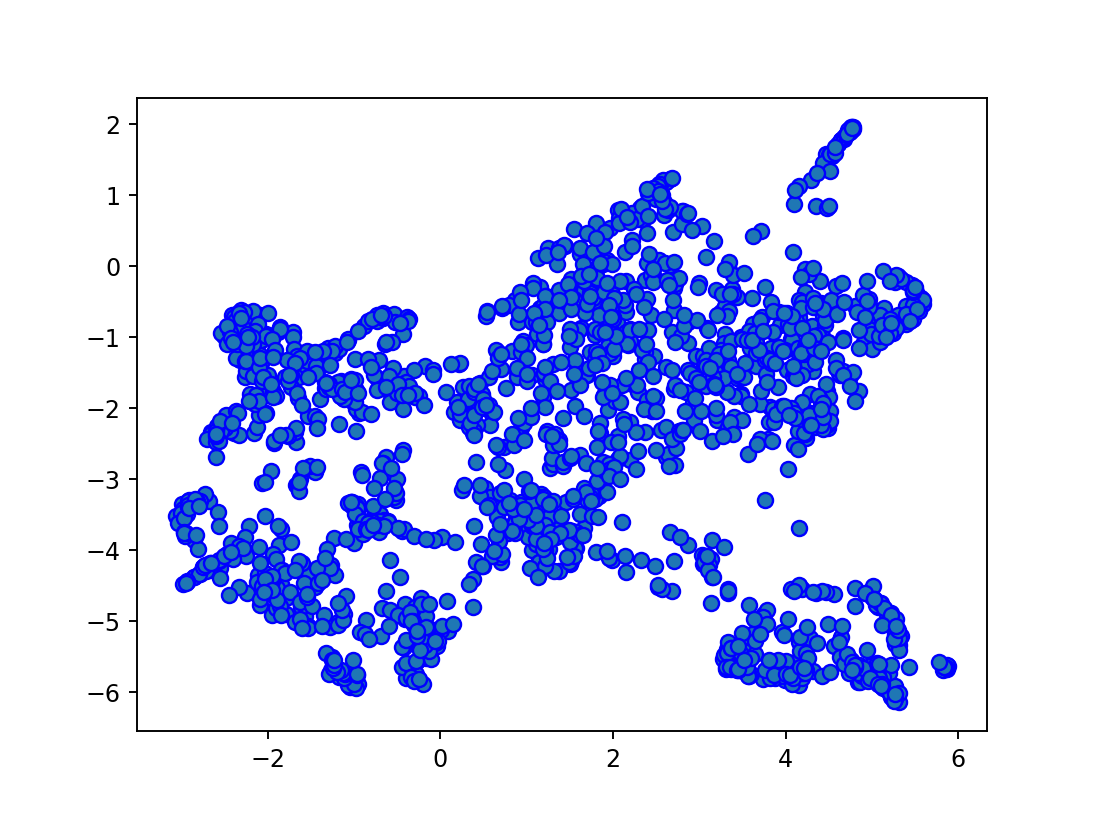

In [33]:
fig, ax = plt.subplots()
ax.scatter(umaped_v[:, 0], umaped_v[:, 1], edgecolor='b', s=40)
plt.show()

Структура очевидно есть. Хорошо бы попытаться выявить ее при помощи кластеризации.<br>
Для начала попробуем <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D1%85">метод k средних (k-means)</a>. Суть метода состоит в том, что мы кидаем k точек (центроидов) случайным образом. Далее мы определяем какие точки данных ближе к каким центроидам и пересчитываем положение центроидов. После нескольких шагов ситуация должна застабилизироваться.<br>
Проведем такую кластеризацию и посмотрим на результаты.

In [34]:
from sklearn.cluster import KMeans

<IPython.core.display.Javascript object>


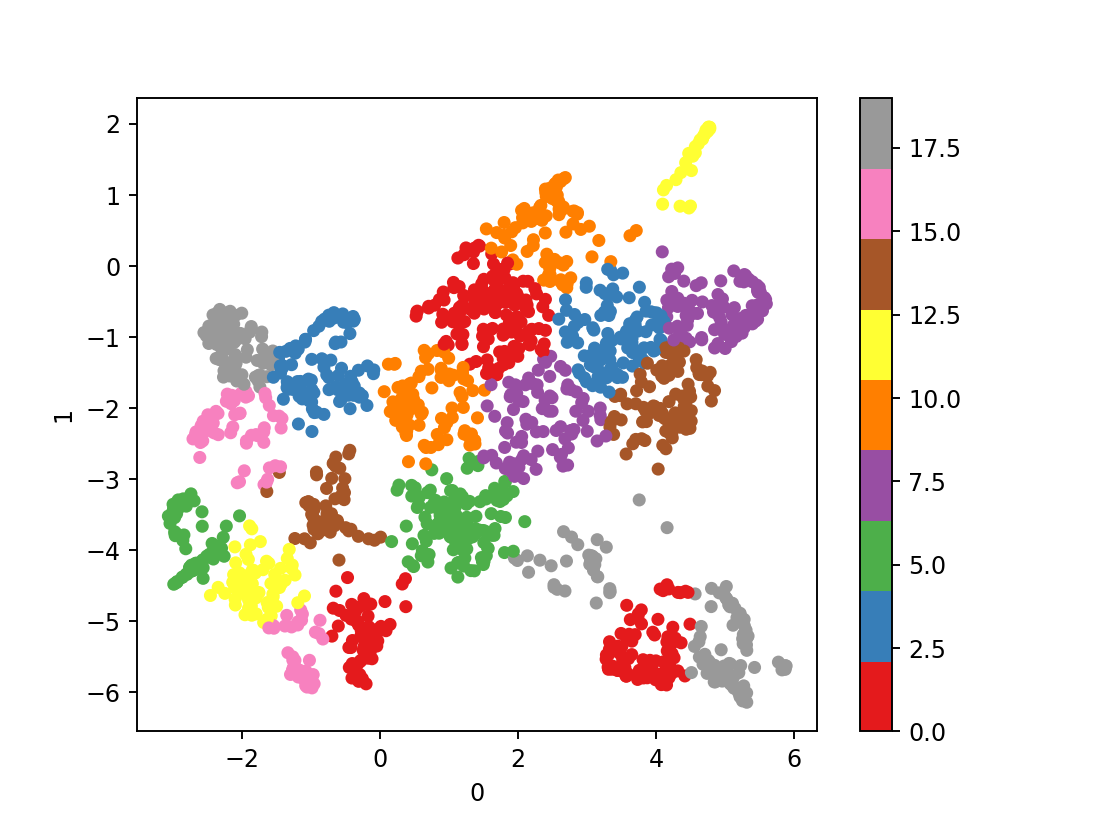

In [35]:
km=KMeans(n_clusters=20)
km_clusters=km.fit_predict(umaped_v)
ax=pd.DataFrame(umaped_v).plot.scatter(x=0, y=1, c=km_clusters, cmap=plt.cm.Set1)

<a href="https://en.wikipedia.org/wiki/Spectral_clustering">Методу спектральной классификации</a> также требуется передать на вход количество кластеров.

In [36]:
from sklearn.cluster import SpectralClustering

<IPython.core.display.Javascript object>


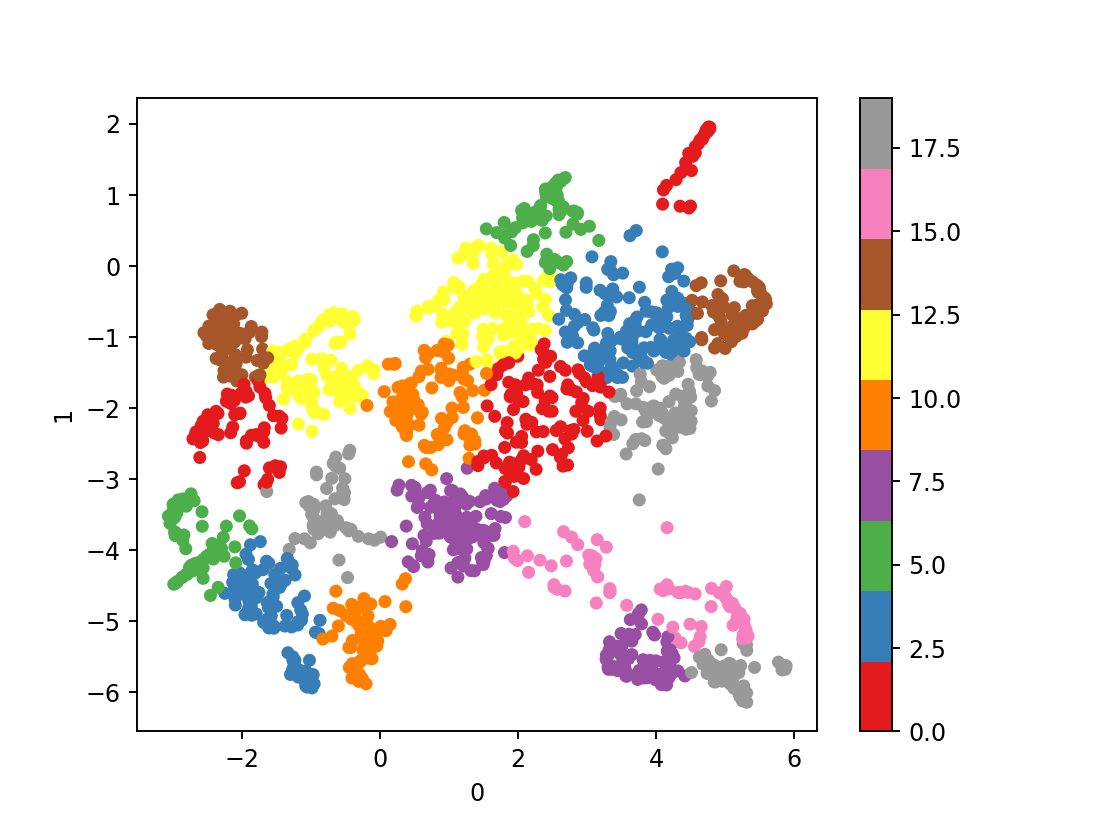

In [37]:
sc=SpectralClustering(n_clusters=20)
sc_clusters=sc.fit_predict(umaped_v)
ax=pd.DataFrame(umaped_v).plot.scatter(x=0, y=1, c=sc_clusters, cmap=plt.cm.Set1)

Также попробуемм <a href="https://en.wikipedia.org/wiki/DBSCAN">метод DB-SCAN</a>, который веделяет области с наибольшей плотностью точек и последовательно включает в кластер точки, находящиеся ближе определенной границы к точкам, уже включенным в кластер. Данному методу не надо указывать количество кластеров, он сам их определит. Но лучше задать правдоподобные параметры eps и min_samples.

In [38]:
from sklearn.cluster import DBSCAN

<IPython.core.display.Javascript object>


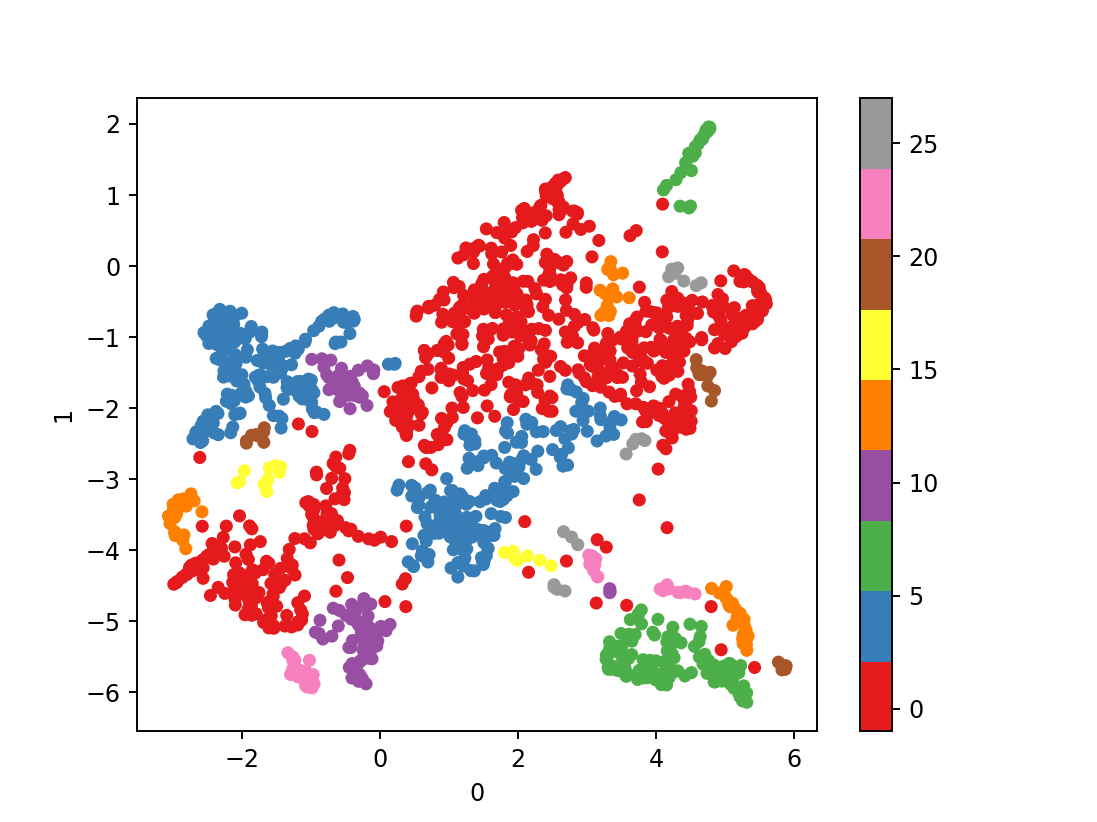

In [40]:
db=DBSCAN(eps=0.2, min_samples=3)
db_clusters=db.fit_predict(umaped_v)
ax=pd.DataFrame(umaped_v).plot.scatter(x=0, y=1, c=db_clusters, cmap=plt.cm.Set1)

df=pd.DataFrame(umaped_v)
df.plot.scatter(x=0, y=1, c=db_clusters, cmap=plt.cm.Set1)

Но давайте взглянем что выдается для каждого из кластеров.

In [41]:
clusters=list(set(db_clusters))

for c in clusters:
    print(c)
    cntr=0
    for i, a in enumerate(lentaPos.articles):
        if db_clusters[i]==c:
            print(a.split("-----")[0])
            cntr+=1
            if cntr==3:
                break

0
Раскрыто происхождение новейшей украинской крылатой ракеты

Названа причина исчезновения рыболовецкого судна «Восток»

С космодрома Восточный запустили третью ракету

1
Русских гопников назвали настоящими древними славянами

Защитники животных предложили сделать черепашек-ниндзя веганами

Ушастый лисенок из России стал мировой знаменитостью

2
Поезд с американскими политиками врезался в мусоровоз

Звезду сериала «Детективы» задержали за работу детектива

Учитель угодил под суд за оральный секс со спящим школьником

3
Открыт первый европейский бордель с секс-куклами вместо проституток

Защитников отечества защитят от некачественной выпивки

Россиянин заплатил налог с комиссией в 2500 процентов

4
Социологи подсчитали планирующих проголосовать на выборах-2018

Украинский депутат призвал к убийствам «непатриотов»

Британский лорд опоздал на заседание и уволился со стыда

5
Ближний Восток становится центром роскоши

Telegram пропал из AppStore

Любителей порно признали самыми удобными же

А вот что выдается по k средних.

In [42]:
clusters=list(set(db_clusters))

for c in clusters:
    print(c)
    cntr=0
    for i, a in enumerate(lentaPos.articles):
        if km_clusters[i]==c:
            print(a.split("-----")[0])
            cntr+=1
            if cntr==3:
                break

0
Поезд с американскими политиками врезался в мусоровоз

Учитель угодил под суд за оральный секс со спящим школьником

Прятавший трупы в цветочных горшках серийный убийца попался в Канаде

1
Террористы похвастались фотографиями и лишились захваченных российских танков

Убит готовивший теракт в день выборов президента России боевик ИГ

Ликвидацию готовившего теракт к президентским выборам боевика сняли на видео

2
Власти США обвинили МОК и ФИФА в коррупции

Пожизненно отстраненных российских спортсменов оправдали

В Кремле порадовались за оправданных российских спортсменов

3
Telegram пропал из AppStore

Любителей порно признали самыми удобными жертвами

У Илона Маска кончились огнеметы

4
Ушастый лисенок из России стал мировой знаменитостью

Китайская детская задачка поставила в тупик взрослых по всему миру

Джима Керри загадочно оправдали по делу о суициде подруги

5
С космодрома Восточный запустили третью ракету

В Поморье ученые раскрыли секрет красного снега

Найдено решение главно